In [0]:
# All the install statements for colab
!pip install -q gpflow
!pip install -q tensorflow"

/bin/bash: -c: line 0: unexpected EOF while looking for matching `"'
/bin/bash: -c: line 1: syntax error: unexpected end of file


In [0]:
# All your import statements here
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib import cm
from matplotlib import gridspec
import gpflow
import itertools
import sys
is_colab = 'google.colab' in sys.modules
print(is_colab)
print(sys.version)
MISS_VARIANCE = 1

True
3.6.6 (default, Sep 12 2018, 18:26:19) 
[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]


In [0]:
# define the matplotlib function to be used
def plot(img):
  plt.figure()
  plt.contourf(img, cmap=plt.cm.Blues)
  plt.colorbar()
  plt.show()
  return

In [0]:
# generate data either complete or with missing observations
def generate_data(missing=False, style='parabola'):
  if style=='parabola':
    # declare a grid
    x1 = np.arange(-25, 25, 1)/100
    x2 = np.arange(-25, 25, 1)/100
    miss = None
    # create observations on the grid and add some noise. Right now using sine
    X, Y = np.meshgrid(x1, x2)
    size = Y.shape[0] * Y.shape[1]
    z = X**2/4 + Y**2/8
  if style=='double':
    # declare a grid
    x1 = np.arange(-25, 25, 1)/100
    x2 = np.arange(-25, 25, 1)/100
    miss = None
    # create observations on the grid and add some noise. Right now using sine
    X, Y = np.meshgrid(x1, x2)
    size = Y.shape[0] * Y.shape[1]
    z = X**3 + Y**3
  if style=='sine':
    # declare a grid
    x1 = np.arange(-25, 25, 1)
    x2 = np.arange(-25, 25, 1)
    miss = None
    # create observations on the grid and add some noise. Right now using sine
    X, Y = np.meshgrid(x1, x2)
    size = Y.shape[0] * Y.shape[1]
    z = np.sin(X) + Y
  if missing:
    points = np.reshape(np.random.uniform(-1, 1, 50 * 50), (50, 50))
    miss = points > -0.5
    points = np.sum(miss)
    z[miss] = np.random.normal(0, MISS_VARIANCE, points)
    print(np.sum(miss)/ size *100)
  plot(z)
  return z, miss

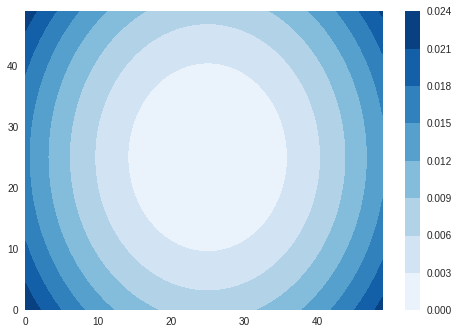

In [0]:
data, _ = generate_data(style='parabola')

74.2


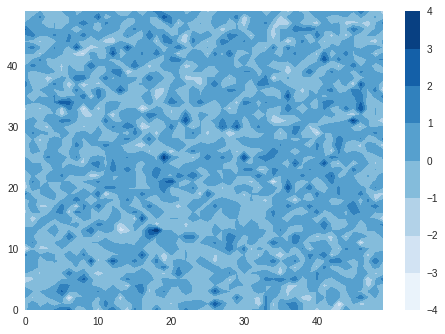

In [0]:
data_miss, miss = generate_data(missing=True, style='double')

In [0]:
def squared_exponential_kernel(shape, l=2, sigma_f=0.1):
  x = np.arange(0, shape, 1)
  y = np.arange(0, shape, 1)
  iters = list(itertools.product(x, y))
  K = np.zeros((shape*shape, shape*shape))
  count = 0
  for i, list_i in enumerate(iters):
    x_i = np.array(list_i)
    for j, list_j in enumerate(iters):
      x_j = np.array(list_j)
      diff = x_i - x_j
      K[i, j] = sigma_f**2 * np.exp(-1 * diff.T.dot(diff)/(2*l**2))
  plot(K)
  return K

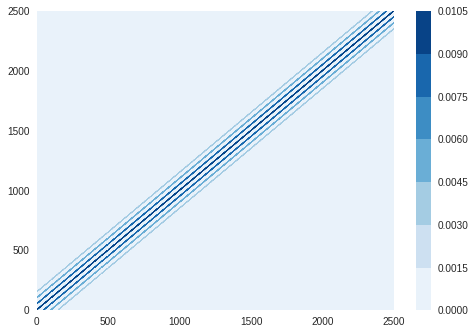

In [0]:
K_test = squared_exponential_kernel(50)

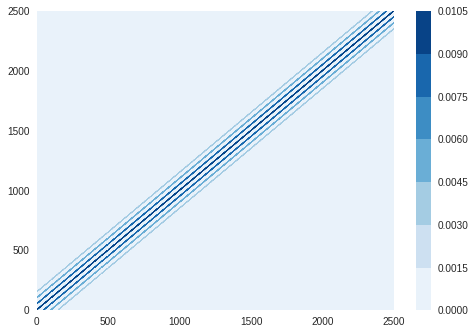

In [0]:
K_noise = squared_exponential_kernel(50, noise=True)

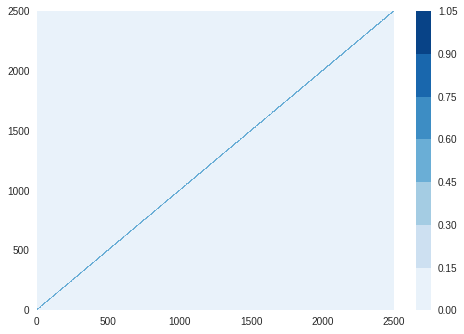

In [0]:
K_missing = squared_exponential_kernel(50, noise=True, missing=True, miss=miss)

In [0]:
def convolution_missing(data, K, K_test):
  tf.reset_default_graph()
  gr = tf.get_default_graph()
  y_train = tf.convert_to_tensor(np.ndarray.flatten(data))
  input_vector = np.array(K)

  # tensorflow
  # rehape k2
  k1, k2 = input_vector.shape
  input_vector = np.expand_dims(input_vector, axis=0)
  input_vector = np.expand_dims(input_vector, axis=3)
  print(input_vector.shape)
  print(k2)
  conv1 = tf.layers.conv2d(
          inputs=tf.convert_to_tensor(input_vector),
          filters=1,
          kernel_size=[1, k2],
          name="conv1",
          use_bias=False,
          padding="valid")

  # define loss
  conv1 = tf.reshape(conv1, [k1])
  # loss = tf.nn.l2_loss(conv1 - y_train)
  loss = tf.reduce_sum(gr.get_tensor_by_name('conv1/kernel:0'))
  # optimization step
  optimizer = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss)

  init_op = tf.global_variables_initializer()

  with tf.Session() as sess:
    sess.run(init_op)
    print(conv1)
    print(y_train)
    loss_plot = []
    for i in range(10000):
      sess.run(optimizer)
      append = loss.eval({}, sess)
      # print(sess.run(conv1))
      # recover graph
      if i%1000 == 0:
        gr = tf.get_default_graph()
        conv1_kernel_val = gr.get_tensor_by_name('conv1/kernel:0').eval()
        v = np.reshape(conv1_kernel_val, (k1))
        # print(v.shape)
        print('conv1:', conv1.eval({}, sess))
        print('loss: ', append)
        loss_plot.append(append)
        # plot new image
        img = K_test.dot(v)
        img = np.reshape(img, (50, 50))
        plot(img)
  plt.plot(loss_plot)
  sess.close()
  return

(1, 2500, 2500, 1)
2500
Tensor("Reshape:0", shape=(2500,), dtype=float64)
Tensor("Const:0", shape=(2500,), dtype=float64)
conv1: [-0.0013242  -0.00176778 -0.0021274  ... -0.00159611 -0.00147041
 -0.00106542]
loss:  -24.385708802389907


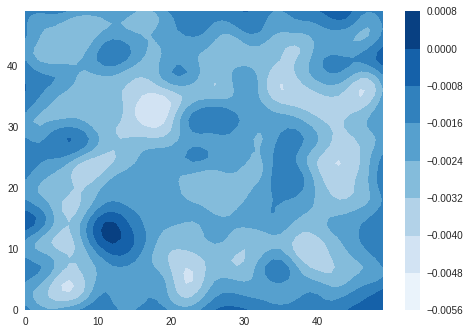

conv1: [-0.90531554 -1.17109312 -1.35381396 ... -1.35328267 -1.17079575
 -0.90505676]
loss:  -25024.385035437812


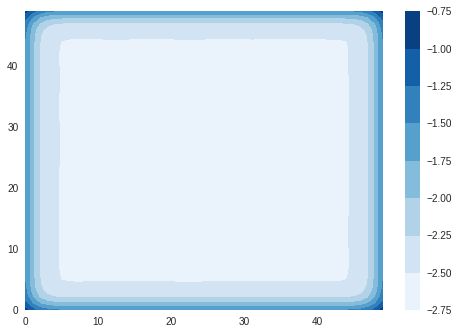

conv1: [-1.80930681 -2.34041838 -2.70550042 ... -2.70496914 -2.34012101
 -1.80904803]
loss:  -50024.382666771155


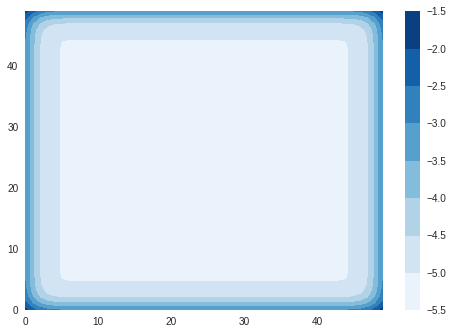

conv1: [-2.7132981  -3.50974367 -4.05718691 ... -4.05665563 -3.50944629
 -2.71303932]
loss:  -75024.38073436893


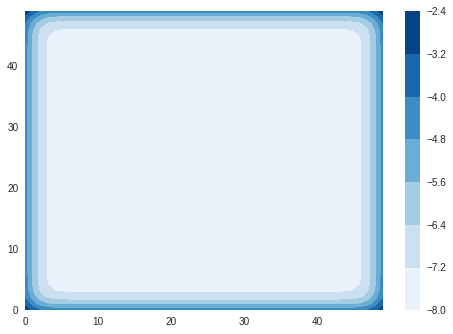

conv1: [-3.6172894  -4.67906896 -5.40887342 ... -5.40834214 -4.67877159
 -3.61703062]
loss:  -100024.37910399407


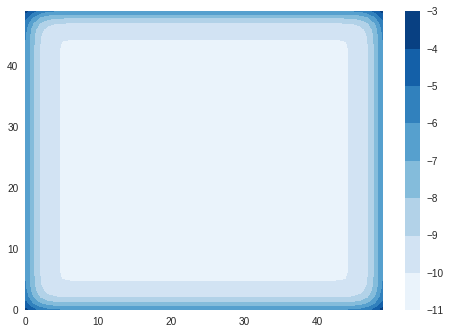

conv1: [-4.52128072 -5.84839429 -6.76055996 ... -6.76002867 -5.84809691
 -4.52102194]
loss:  -125024.37806083458


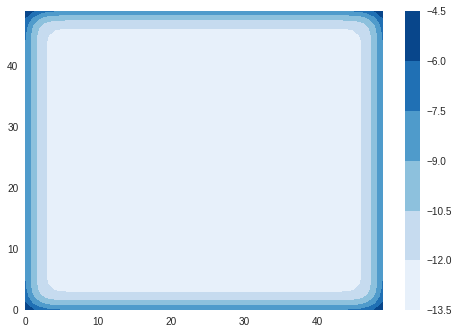

KeyboardInterrupt: ignored

In [0]:
convolution_missing(data, K_noise, K_test)

(1, 2500, 2500, 1)
2500
Tensor("Reshape:0", shape=(2500,), dtype=float64)
Tensor("Const:0", shape=(2500,), dtype=float64)
conv1: [ 0.00123046  0.00132869  0.02114723 ... -0.00028156  0.01625405
 -0.00046929]
loss:  869.9663701789763


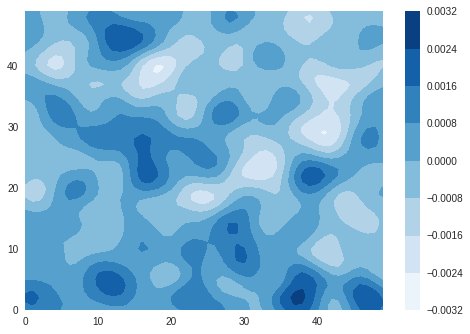

conv1: [-0.03427199 -0.0428094   0.09618167 ...  0.0088288   1.18400766
  0.02016624]
loss:  0.1585847391390113


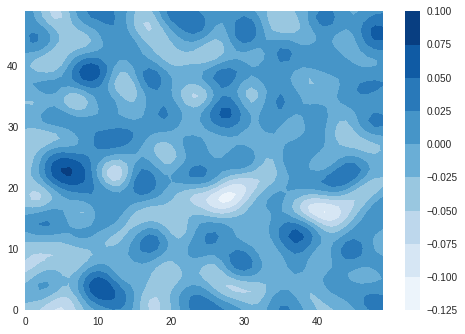

conv1: [-0.02829809 -0.03530919  0.09604932 ...  0.01563055  1.18387767
  0.02831874]
loss:  0.03369317189852362


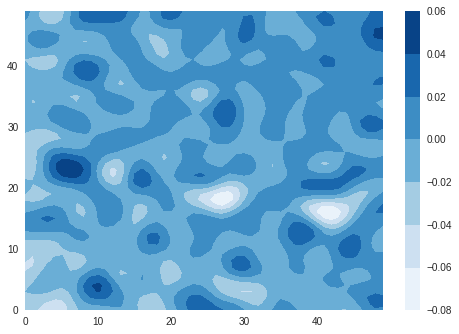

conv1: [-0.02823771 -0.03209829  0.09596321 ...  0.02110855  1.18380158
  0.02845297]
loss:  0.012571625847905341


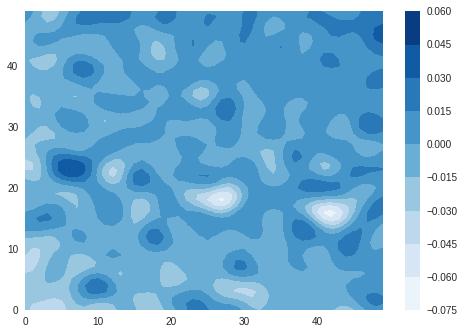

conv1: [-0.02880252 -0.02993779  0.09591044 ...  0.02387812  1.18378914
  0.0272176 ]
loss:  0.005907719423976057


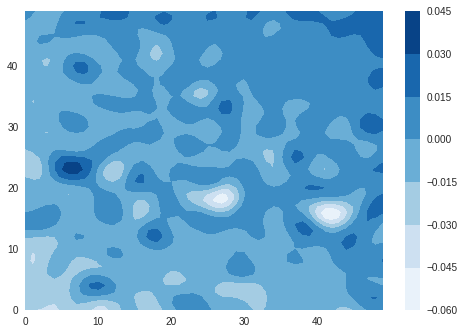

conv1: [-0.02914351 -0.02872045  0.09588692 ...  0.02485218  1.18378563
  0.02702527]
loss:  0.003071341618886396


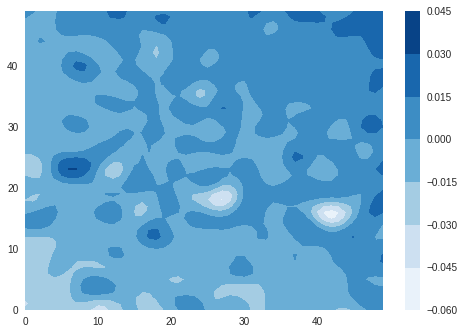

conv1: [-0.0297317  -0.02851203  0.09600556 ...  0.02508494  1.18378369
  0.0269749 ]
loss:  0.001708956126174443


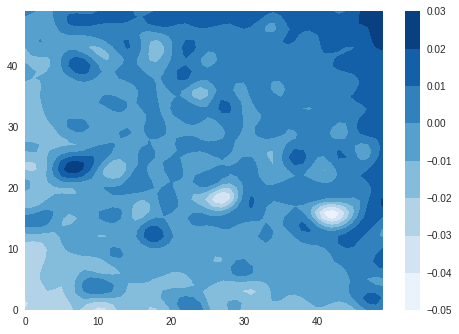

conv1: [-0.03032097 -0.02878638  0.09590235 ...  0.02501007  1.1837826
  0.02696697]
loss:  0.0009864797128851742


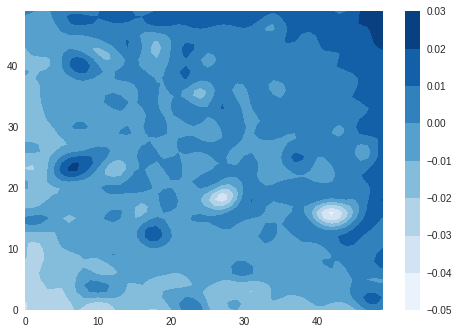

conv1: [-0.03065667 -0.0291414   0.09540014 ...  0.02488188  1.18378348
  0.02705183]
loss:  0.0005763912808435352


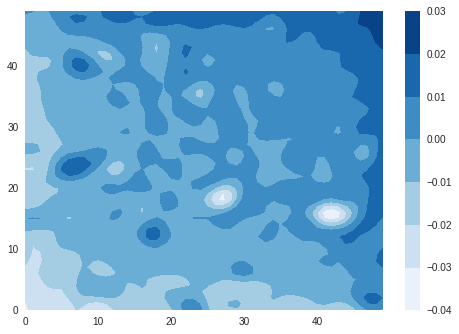

conv1: [-0.03073962 -0.02932805  0.0958966  ...  0.02480169  1.18378276
  0.02716595]
loss:  0.0003257151113001116


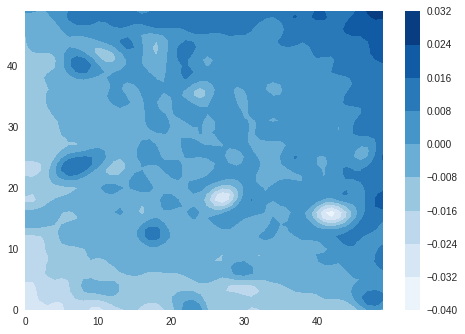

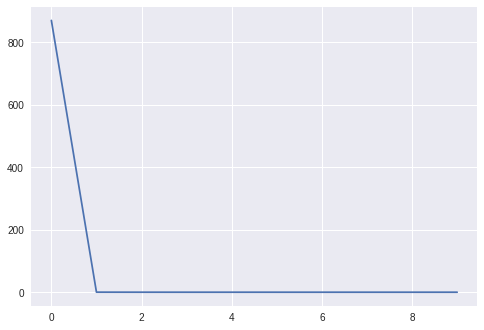

In [0]:
convolution(data_miss, K_missing, K_test)

In [0]:
# TODO: Vectorize the co-variance matrix calculation
def test():
  A = np.zeros((3,3,2))
  A[np.arange(3),:,1] = np.arange(3)
  A[:, np.arange(3),0] = A[np.arange(3),:,1].T
  A = A.reshape(9,2)
  A = A.reshape(1,9,2) - A.reshape(9,1,2)
  A = A.reshape(81,2)
  ans = A.dot(A.T)
  ans = ans[np.arange(81),np.arange(81)]
  return ans.shape

In [0]:
test()

(81,)

In [0]:
A = A.reshape(81,2)
ans = A.dot(A.T)
ans = ans[np.arange(81),np.arange(81)]
ans = ans.reshape(9,9)
print(ans)

[[0. 1. 4. 1. 2. 5. 4. 5. 8.]
 [1. 0. 1. 2. 1. 2. 5. 4. 5.]
 [4. 1. 0. 5. 2. 1. 8. 5. 4.]
 [1. 2. 5. 0. 1. 4. 1. 2. 5.]
 [2. 1. 2. 1. 0. 1. 2. 1. 2.]
 [5. 2. 1. 4. 1. 0. 5. 2. 1.]
 [4. 5. 8. 1. 2. 5. 0. 1. 4.]
 [5. 4. 5. 2. 1. 2. 1. 0. 1.]
 [8. 5. 4. 5. 2. 1. 4. 1. 0.]]


array([[0., 1., 4., 1., 2., 5., 4., 5., 8.],
       [1., 0., 1., 2., 1., 2., 5., 4., 5.],
       [4., 1., 0., 5., 2., 1., 8., 5., 4.],
       [1., 2., 5., 0., 1., 4., 1., 2., 5.],
       [2., 1., 2., 1., 0., 1., 2., 1., 2.],
       [5., 2., 1., 4., 1., 0., 5., 2., 1.],
       [4., 5., 8., 1., 2., 5., 0., 1., 4.],
       [5., 4., 5., 2., 1., 2., 1., 0., 1.],
       [8., 5., 4., 5., 2., 1., 4., 1., 0.]])

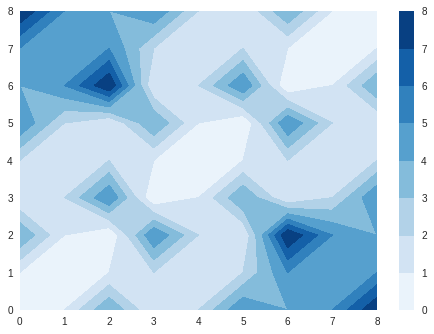

In [0]:
N = data.shape[0]
sigma_f = 0.1
l = 2

In [0]:
def conv_kernel(N, noise=False):
  K_prime = np.zeros((2*N-1, 2*N-1))
  count_i = 0
  for i in np.arange(-1*(N-1), N, 1):
    count_j = 0
    for j in np.arange(-1*(N-1), N, 1):
      K_prime[count_i, count_j] = sigma_f**2 * np.exp(-1 * np.sqrt(i**2+j**2)/(2*l**2))
      if i == 0 and j == 0 and noise:
        K_prime[count_i, count_j] += 1e-6
      count_j += 1
    count_i += 1
  return K_prime

In [0]:
K_prime = conv_kernel(N)
K_test = conv_kernel(N, noise=True)
K_test

array([[1.73027837e-06, 1.88931637e-06, 2.06105456e-06, ...,
        2.06105456e-06, 1.88931637e-06, 1.73027837e-06],
       [1.88931637e-06, 2.06485292e-06, 2.25462161e-06, ...,
        2.25462161e-06, 2.06485292e-06, 1.88931637e-06],
       [2.06105456e-06, 2.25462161e-06, 2.46412233e-06, ...,
        2.46412233e-06, 2.25462161e-06, 2.06105456e-06],
       ...,
       [2.06105456e-06, 2.25462161e-06, 2.46412233e-06, ...,
        2.46412233e-06, 2.25462161e-06, 2.06105456e-06],
       [1.88931637e-06, 2.06485292e-06, 2.25462161e-06, ...,
        2.25462161e-06, 2.06485292e-06, 1.88931637e-06],
       [1.73027837e-06, 1.88931637e-06, 2.06105456e-06, ...,
        2.06105456e-06, 1.88931637e-06, 1.73027837e-06]])

In [0]:
def convolution(data, K, K_test, N):
  tf.reset_default_graph()
  y_train = tf.convert_to_tensor(np.ndarray.flatten(data))
  input_vector = np.array(K)
  print(N)
  
  # tensorflow
  # rehape k2
  k1, k2 = input_vector.shape
  input_vector = np.expand_dims(input_vector, axis=0)
  input_vector = np.expand_dims(input_vector, axis=3)
  print(input_vector.shape)
  print(k2)
  
  conv1 = tf.layers.conv2d(
          inputs=tf.convert_to_tensor(input_vector),
          filters=1,
          kernel_size=[N, N],
          name="conv1",
          use_bias=False,
          padding="valid")

  # define loss
  loss = tf.nn.l2_loss(conv1 - y_train)
  n = K_test.shape[0]
  K_test = tf.convert_to_tensor(K_test)
  K_test = tf.reshape(K_test, [1, n, n, 1])
  
  # optimization step
  optimizer = tf.train.AdamOptimizer(learning_rate=0.1).minimize(loss)

  init_op = tf.global_variables_initializer()

  with tf.Session() as sess:
    sess.run(init_op)
    print(conv1)
    print(y_train)
    loss_plot = []
    for i in range(3000):
      sess.run(optimizer)
      append = loss.eval({}, sess)
      # print(sess.run(conv1))
      # recover graph
      if i%100 == 0:
        gr = tf.get_default_graph()
        # print(v.shape)
        print('loss: ', append)
        loss_plot.append(append)
        # plot new image
        img = conv1.eval({}, sess)
        img = np.reshape(img, (50, 50))
        plot(img)
  plt.plot(loss_plot)
  sess.close()
  return

50
(1, 99, 99, 1)
99
Tensor("conv1/Conv2D:0", shape=(1, 50, 50, 1), dtype=float64)
Tensor("Const:0", shape=(2500,), dtype=float64)
loss:  202686.32764582755


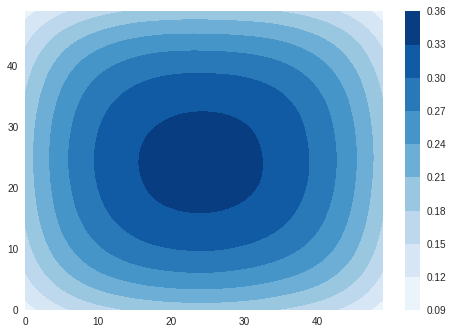

loss:  87.8132595346552


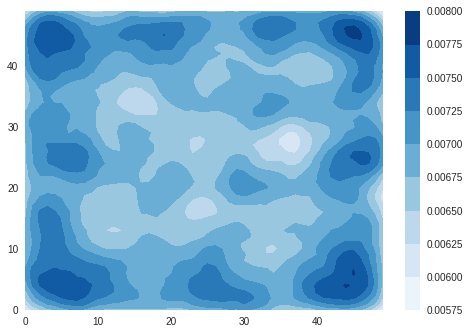

loss:  85.21518542825063


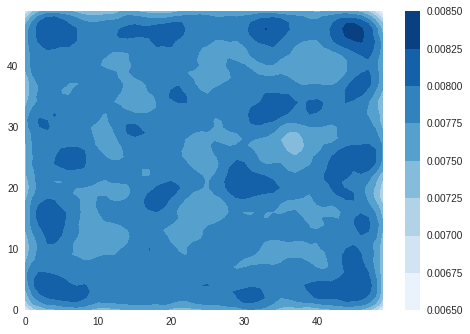

loss:  85.18102734020758


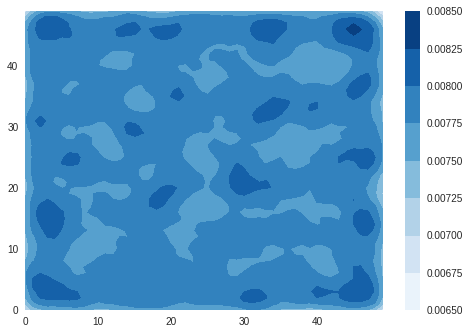

loss:  85.16349506105888


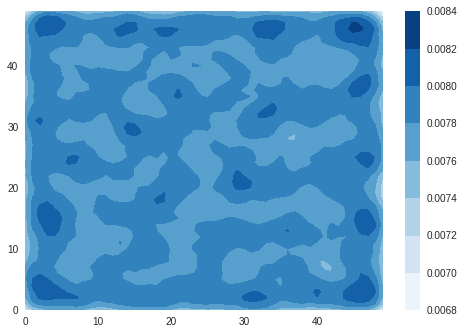

loss:  85.15291528160904


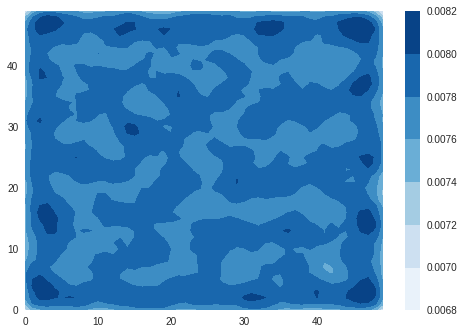

loss:  85.1458642193891


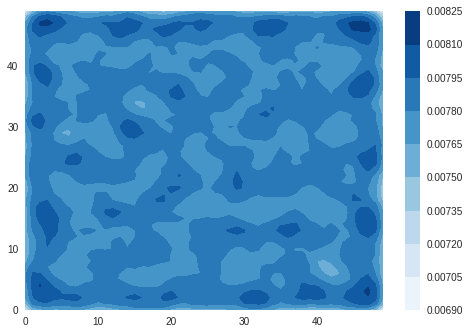

loss:  85.14076142546091


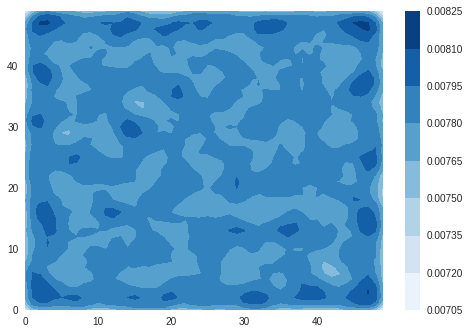

loss:  85.13686697574576


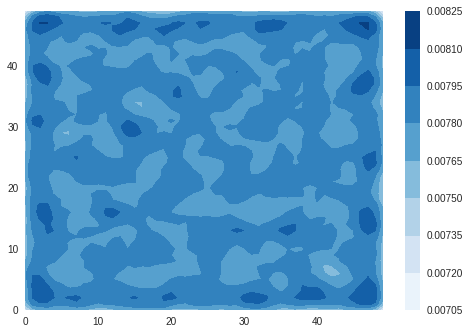

loss:  85.13379904430981


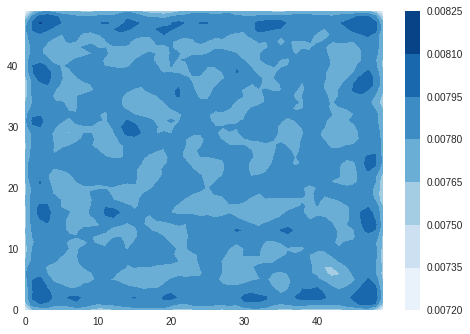

loss:  85.13132491231626


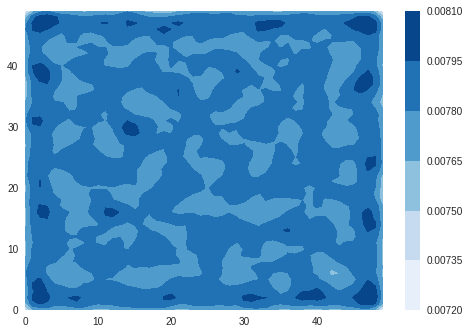

loss:  85.1292849153827


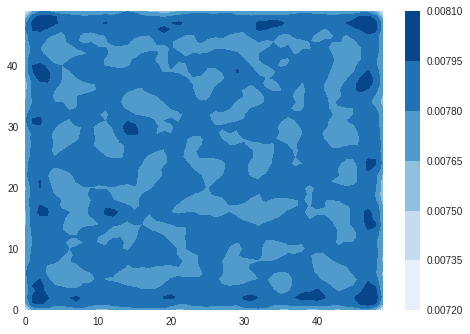

loss:  85.12756599828109


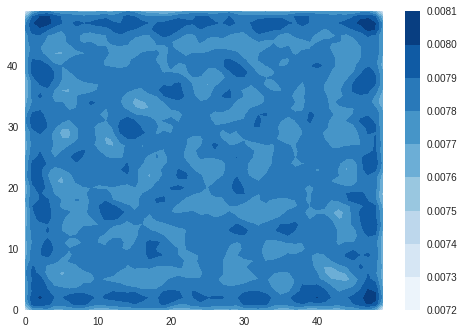

loss:  85.1260891709342


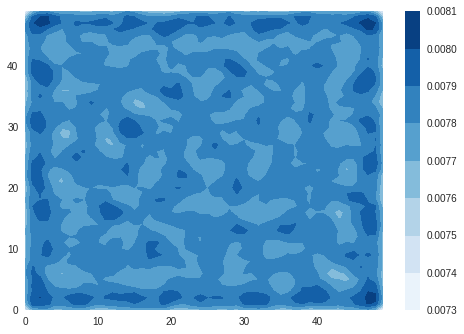

loss:  85.1248002974319


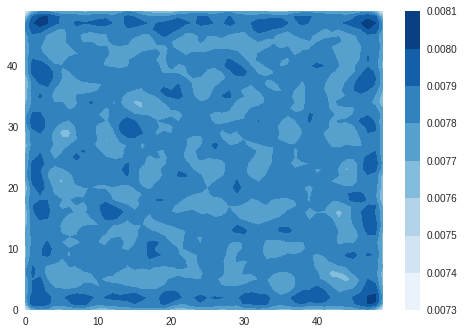

loss:  85.12366244307778


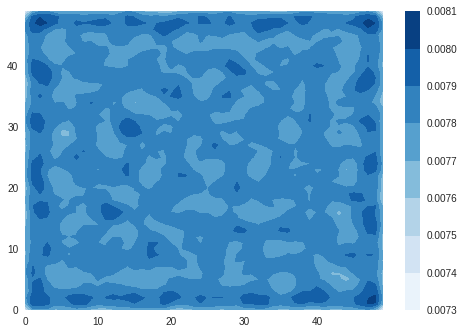

loss:  85.12264989068211


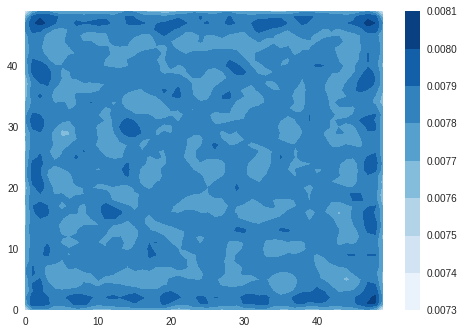

loss:  85.12174389304275


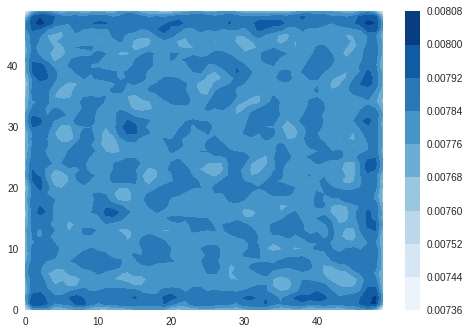

loss:  85.12092994022524


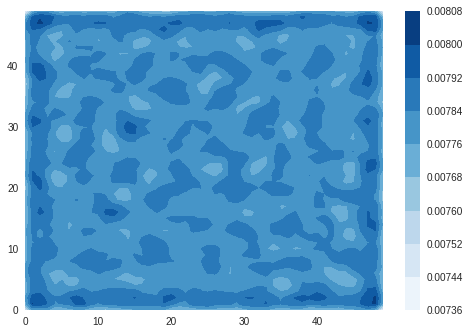

loss:  85.12019615997657


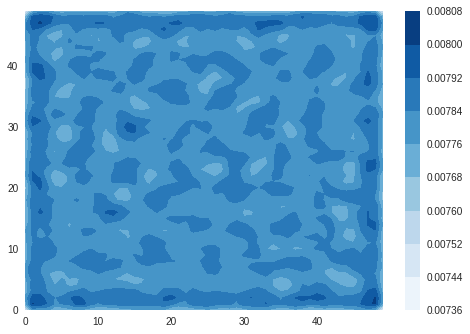

loss:  519.0136395290186


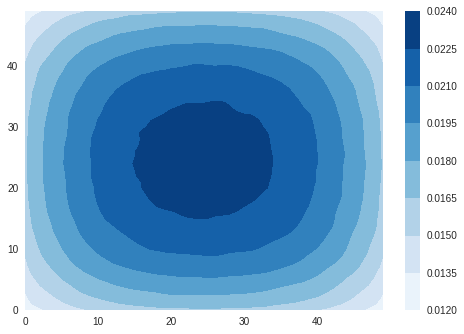

loss:  85.13758795727809


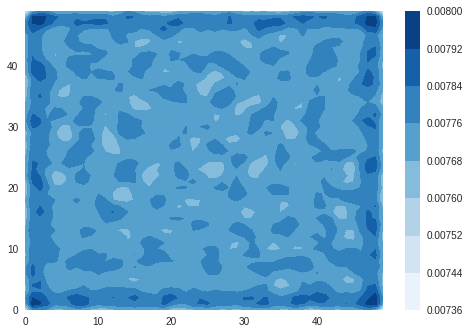

loss:  85.1186331312614


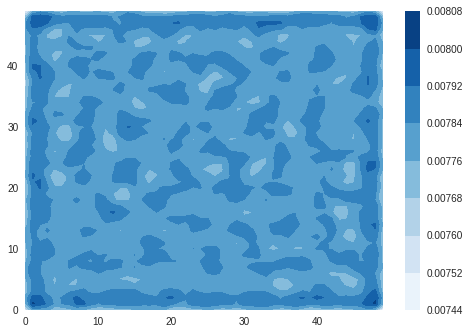

loss:  85.1182086545721


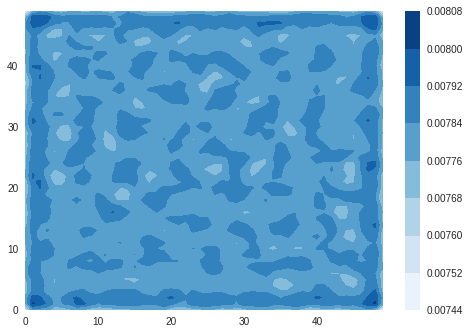

loss:  95.3514711604061


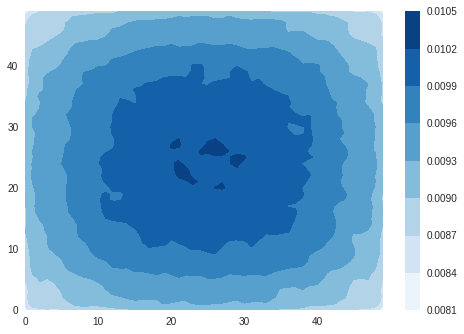

loss:  85.11753967327354


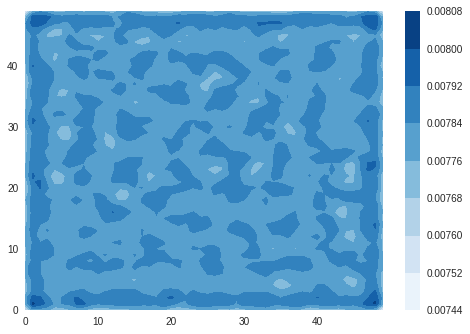

loss:  85.11720918514621


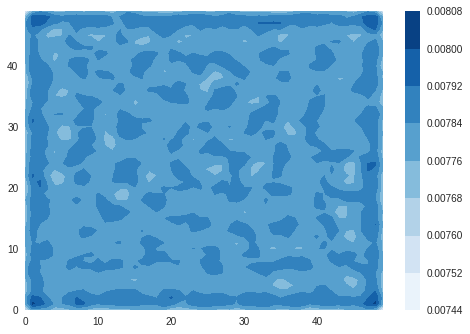

loss:  85.11693057335583


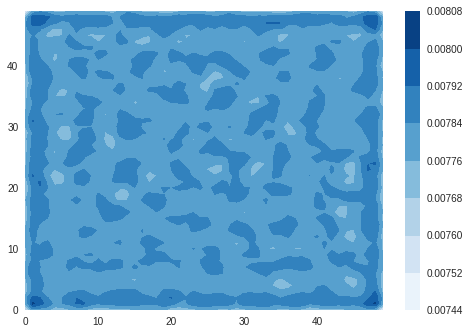

loss:  85.11666743356145


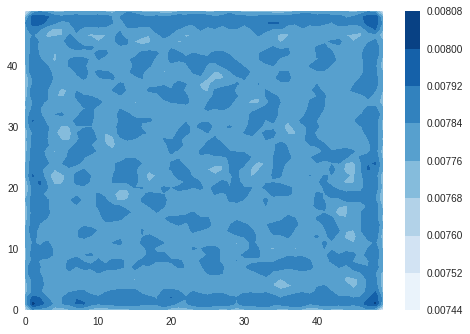

loss:  95.63956291888724


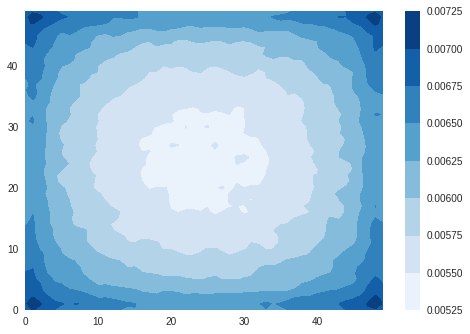

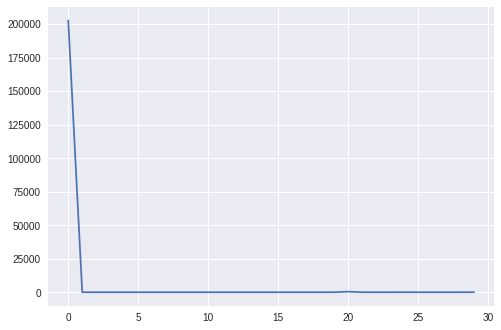

In [0]:
convolution(data, K_prime, K_test, N)